***Dr. Emmanuel Dufourq*** www.emmanueldufourq.com

***African Institute for Mathematical Sciences***

***2019***


Credits: The data imports and tokenisation were extracted from https://github.com/rstudio/keras/blob/master/vignettes/examples/pretrained_word_embeddings.R

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

In [84]:
devtools::install_github("rstudio/keras")

Skipping install of 'keras' from a github remote, the SHA1 (34dc89ed) has not changed since last install.
  Use `force = TRUE` to force installation


## Import the Keras library

In [0]:
library(keras)
library(stringr)

## Load the IMDB dataset

Here we load the IMDB dataset and specify that we want the top 10,000 most frequent words. Which which occur less frequently than the top 10,000 will be discarded. 

In practice we can also use other techniques such as stop-word removal and tf-idf to get rid of certain "rare" words which don't add much value to the classification process.

_***Loading this data set can take a minute or two***_

## Function to download the data

In [0]:
download_data <- function(data_dir, url_path, data_file) {
  if (!dir.exists(data_dir)) {
    download.file(paste0(url_path, data_file), data_file, mode = "wb")
    if (tools::file_ext(data_file) == "zip")
      unzip(data_file, exdir = tools::file_path_sans_ext(data_file))
    else
      untar(data_file)
    unlink(data_file)
  }
}

## Download data

In [0]:
TEXT_DATA_DIR <- '20_newsgroup'
download_data(TEXT_DATA_DIR, "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/", "news20.tar.gz")

## Splitting the data into features and targets

In [0]:
texts <- character()  # text samples
labels <- integer() # label ids
labels_index <- list()  # dictionary: label name to numeric id

for (name in list.files(TEXT_DATA_DIR)) {
  path <- file.path(TEXT_DATA_DIR, name)
  if (file_test("-d", path)) {
    label_id <- length(labels_index)
    labels_index[[name]] <- label_id
    for (fname in list.files(path)) {
      if (grepl("^[0-9]+$", fname)) {
        fpath <- file.path(path, fname)
        t <- readLines(fpath, encoding = "latin1")
        t <- paste(t, collapse = "\n")
        i <- regexpr(pattern = '\n\n', t, fixed = TRUE)[[1]]
        if (i != -1L)
          t <- substring(t, i)
        texts <- c(texts, t)
        labels <- c(labels, label_id)
      }
    }
  }
}

## Look at a data point

In [89]:
texts[1230]

[1] "\n\nIn article <1993Apr15.164940.11632@mercury.unt.edu> mcmains@unt.edu (Sean McMains) writes:\n>\n>Wow! A 68070! I'd be very interested to get my hands on one of these,\n>especially considering the fact that Motorola has not yet released the\n>68060, which is supposedly the next in the 680x0 lineup. 8-D\n\nA 68070 is just a 68010 with a built in MMU.  I don't even think that Moto.\nmanufactures them.\n\n                                  - Ian Romanick\n                                    Dancing Fool of Epsilon\n\n[]--------------------------------------------------------------------[]\n | Were the contained thoughts 'opinions',     EPN.NTSC.quality = Best|\n | PSU would probably not agree with them.                            |\n |                                                                    |\n | \"Look, I don't know anything about                                 |\n | douche, but I do know Anti-Freeze                                  |\n | when I see it!\" - The Dead Milkmen                                 |\n[]--------------------------------------------------------------------[]"

## Look at the label

In [90]:
labels[1230]

[1] 1

## Create a tokeniser

We need a method to conver the text into numbers. We can define a tokeniser and fit it to the dataset. We also specify how many words it should attempt to index. This will then find the most common words and assign a value to them.

More information on this function is available here: https://keras.rstudio.com/reference/text_tokenizer.html

In [0]:
tokenizer <- text_tokenizer(num_words=10000)
tokenizer %>% fit_text_tokenizer(texts)

## Convert the text into a sequence of integers

In [0]:
sequences <- texts_to_sequences(tokenizer, texts)

## Check how a sentence was converted into integers

In [93]:
sequences[1230]

[[1]]
 [1]    6   54 1525 4335   26   26 3720   43 4350    4  302   16  117  444    2
[16]   79   33 1284   15   40    3  100  595 1502    1  222    9 2891   52   17
[31]  350 1848    1   61    8 2755    1  342    6    1 7358  102  141    4    8
[46]   69    4   20    4  821    6    7   65  114   84    9 9408   77 5153 3353
[61]    3   70    1 4135 2503 8934  855  259 3175   38  256   17  451   20   77
[76]  221    7   65   74  235   44   24    7   42   74  760   67    7  116   11
[91]    1  628

## Get the word indexing

The word index is a mapping from words to integers.

In [94]:
word_index <- tokenizer$word_index
word_index[0:10]

$`3ds2scn`
[1] 87028

$`9l2t`
[1] 89948

$l1tbk
[1] 124151

$nunnery
[1] 27554

$porkification
[1] 158185

$luanch
[1] 157608

$woods
[1] 7169

$spiders
[1] 140427

$mdbs
[1] 40217

$woody
[1] 17418

## Padding

The neural network approach we will use requires that the input is of fixed size. So we cannot use the data in it's current form as each text extract (data point) is a different length. We can fix this by padding the sentences with zeros. Padding is added to the left. To pad we need to specify a maximum length. Each data point which had less words than the maximum length will be padded with zeros so that it reaches the correct length.

In this case we choose the maximum data point length to be 400.

In [0]:
x_data <- sequences %>% pad_sequences(maxlen = 400)

## Checking our labels

This is a multiclass classification problem with 20 classes.

In [96]:
unique(labels)

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

## Apply one-hot encoding

In [0]:
y_data <- to_categorical(labels)

## Split data into training and testing

In [0]:
indices <- 1:nrow(x_data)
indices <- sample(indices)
data <- x_data[indices,]
y_data <- y_data[indices,]
num_validation_samples <- as.integer(0.2 * nrow(x_data))

x_train <- x_data[-(1:num_validation_samples),]
y_train <- y_data[-(1:num_validation_samples),]
x_val <- x_data[1:num_validation_samples,]
y_val <- y_data[1:num_validation_samples,]

## Check dimensions

In [99]:
dim(x_train)

[1] 15998   400

In [100]:
dim(x_val)

[1] 3999  400

In [101]:
dim(y_train)

[1] 15998    20

In [102]:
dim(y_val)

[1] 3999   20

## Create a model

In [0]:
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = 10000, output_dim = 32, input_length = 400) %>% #embedding layer
  layer_dropout(0.2) %>%
  layer_conv_1d(filters = 32, kernel_size = 3, padding = "valid", activation = "relu", strides = 1) %>%
  layer_global_max_pooling_1d() %>%
  layer_dense(units = 128, activation = 'relu') %>% # the MLP starts here
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 20, activation = 'softmax')

## Compile the model

In [0]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = "adam",
  metrics = "accuracy"
)

## Note the output of 1-D global max pooling

Here, for each of the 100 embedding vectors, the maximum value is computed. In this example, there are 100 embedding vectors of length 398, and thus the maximum value is extracted resulting in a shape of (None, 100).

In [105]:
summary(model)

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_2 (Embedding)             (None, 400, 32)                 320000      
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 400, 32)                 0           
________________________________________________________________________________
conv1d_2 (Conv1D)                   (None, 398, 32)                 3104        
________________________________________________________________________________
global_max_pooling1d_2 (GlobalMaxPo (None, 32)                      0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 128)                     4224        
________________________________________________________________________________
dropou

## Train the model

This takes about 1 minute to train on the GPU instance using 4 epochs

In [0]:
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 3,
  validation_split = 0.2,
  verbose = 0,
  batch_size = 16
)

### Plot the performance

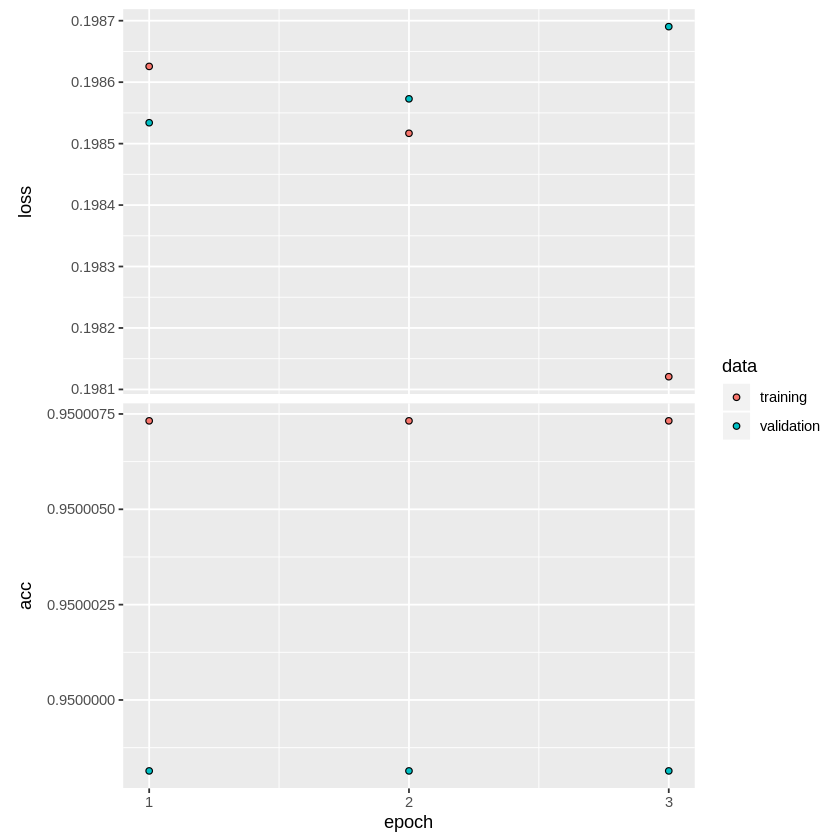

In [107]:
plot(history)

## Evaluate the performance

In [108]:
model %>% evaluate(x_val, y_val)

$loss
[1] 0.198676

$acc
[1] 0.9499989

## Predicting

We can obtain the sigmoid outputs for each test case.

In [109]:
model %>% predict(x_val[1:10,])

0.04965884,0.05002101,0.04869637,0.04895003,0.05109463,0.04729991,0.04747726,0.04863125,0.04998605,0.05049389,0.05643825,0.04576404,0.04563498,0.04971050,0.05354728,0.04505087,0.05472245,0.05006795,0.05022652,0.05652790
0.04711771,0.05123716,0.04688568,0.04909843,0.05089844,0.04784042,0.04324480,0.04942381,0.05342804,0.04904389,0.05646074,0.04648327,0.04767852,0.04992682,0.05448519,0.04465880,0.05767016,0.04644017,0.05174664,0.05623130
0.04606425,0.05261694,0.04915021,0.04534147,0.04549373,0.04925393,0.04571254,0.04975342,0.05252463,0.05041971,0.05498290,0.04997832,0.04670614,0.05012535,0.05609525,0.04845047,0.05079926,0.05358516,0.04970368,0.05324266
0.04928586,0.05285425,0.05036291,0.04381396,0.04779160,0.04897467,0.05002617,0.05088023,0.05287468,0.04928653,0.05170140,0.04809390,0.04717835,0.04945919,0.05345666,0.04896959,0.04981206,0.04825331,0.05163997,0.05528472
0.04921268,0.05210514,0.05230696,0.04448432,0.04723462,0.05150324,0.04845884,0.05046337,0.05051709,0.05178858,0.05037607,0.05193577,0.04811597,0.04948607,0.05363526,0.04800138,0.04935126,0.04735010,0.05259020,0.05108305
0.04550597,0.05280380,0.05028945,0.04673931,0.04625584,0.05101187,0.04334227,0.04913294,0.05112053,0.05341728,0.05223939,0.05309508,0.04671990,0.05192433,0.05693295,0.04723139,0.05178978,0.04942836,0.05156555,0.04945399
0.05447582,0.04991601,0.05184624,0.04741590,0.04479410,0.05076545,0.05020908,0.05103258,0.04721529,0.05241291,0.04963871,0.05081065,0.04785946,0.04819848,0.05571882,0.04454248,0.04937373,0.04773273,0.05424790,0.05179372
0.04432971,0.05480847,0.04898531,0.04226955,0.04684210,0.05064103,0.04378033,0.05065787,0.05414859,0.05171199,0.05325656,0.05142214,0.04632958,0.05133979,0.05511734,0.04900606,0.05270186,0.05082866,0.05017506,0.05164800
0.05078367,0.04995439,0.04960280,0.04566884,0.04447144,0.05146538,0.04528260,0.05102852,0.04989112,0.05329708,0.05119009,0.05324630,0.04845060,0.04987588,0.05935651,0.04394216,0.05035432,0.04756131,0.05477707,0.04979989
0.05047244,0.05092427,0.05208232,0.04531306,0.04753408,0.05094086,0.05005714,0.04864454,0.04986813,0.04897847,0.05211825,0.05065399,0.04668005,0.04971383,0.05559237,0.04759563,0.04969811,0.04716572,0.05338660,0.05258013


Using the `predict_classes` function we can get the binary predictions for each test case.

In [110]:
model %>% predict_classes(x_val[1:10,])

[1] 19 16 14 19 14 14 14 14 14 14